# TestCase4 - ErrorMap

In [1]:
# sélection du cas test
testcase = 4
version = 1
degree = 1
param_num = 1

**Idée :** On se place ici dans le TestCase3.

On cherche à afficher des cartes d'erreur sur la solution.

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns

# from modules.fenics_expressions import UexExpr
from scimba.equations.domain import SpaceTensor
from scimba.equations import domain

from modules.utils import create_tree
from modules.geometry import Donut,Circle
from modules.fenics_expressions_3 import FExpr,AnisotropyExpr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
if testcase == 4:
    if version == 1:
        from modules.testcases.test_4 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4 import FEMSolver
    elif version == 2:
        from modules.testcases.test_4_v2 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut import FEMSolver
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase4
    problem = TestCase4(v=version)
else:
    raise ValueError("Testcase not found")


dim_params = problem.nb_parameters
result_dir = "../../../results/testcase"+str(testcase)
if version != 1:
    result_dir += "_v"+str(version)
result_dir += "/errormap/"
create_tree(result_dir)

tab_nb_vert = [20,40]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

hmax =  0.13332451902950168
hmax =  0.06895832285674866


>> load network /home/flecourtier/Bureau/Article1/networks/test_fe4.pth
jsbdbshd
network loaded


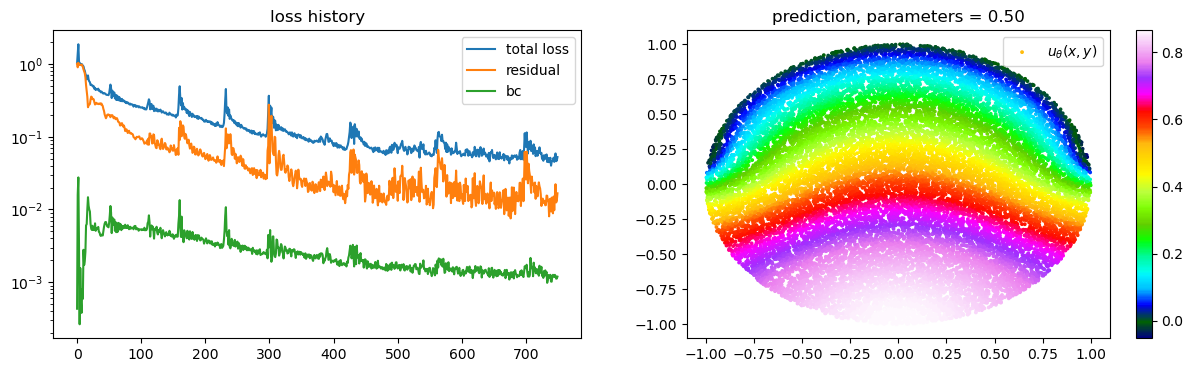

In [12]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [13]:
def get_param(i):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
params = [param]
params_str = np.array([f"{param}"])
params

[array([0.5])]

## Solution de référence

In [14]:
from dolfin import *
prm = parameters["krylov_solver"]
prm["absolute_tolerance"] = 1e-13
prm["relative_tolerance"] = 1e-13

In [15]:
import mshr

def create_ref_domain(deg,nb_vert=500,H=None):    
    # check if pb_considered is instance of Square class
    if isinstance(problem.geometry, Donut):
        bigcenter = problem.geometry.bigcircle.center
        bigradius = problem.geometry.bigcircle.radius
        smallcenter = problem.geometry.hole.center
        smallradius = problem.geometry.hole.radius
        box = np.array(problem.geometry.box)

        bigcircle = mshr.Circle(df.Point(bigcenter[0],bigcenter[1]), bigradius)
        hole = mshr.Circle(df.Point(smallcenter[0],smallcenter[1]), smallradius)
        domain = bigcircle-hole    
    
        mesh_macro = RectangleMesh(Point(box[0,0], box[1,0]), Point(box[0,1], box[1,1]), nb_vert, nb_vert)
        h_macro = mesh_macro.hmax()
        print("h_macro = ",h_macro)
        
        if H is None:
            H = int(nb_vert*3/5)
        else:
            H = int(H)
        mesh_ref = mshr.generate_mesh(domain,H)
        h = mesh_ref.hmax()
        while h > h_macro:
            H += 1
            mesh_ref = mshr.generate_mesh(domain,H)            
            h = mesh_ref.hmax()
            print("h : ",h)
    elif isinstance(problem.geometry, Circle):
        center = problem.geometry.center
        radius = problem.geometry.radius
        box = np.array(problem.geometry.box)

        domain = mshr.Circle(df.Point(center[0],center[1]), radius)        
        mesh_macro = RectangleMesh(Point(box[0,0], box[1,0]), Point(box[0,1], box[1,1]), nb_vert, nb_vert)
        h_macro = mesh_macro.hmax()
        print("h_macro = ",h_macro)
        
        if H is None:
            # H = int(nb_vert*3/5)
            H = 700
        else:
            H = int(H)
        mesh_ref = mshr.generate_mesh(domain,H)
        h = mesh_ref.hmax()
        while h > h_macro:
            H += 1
            mesh_ref = mshr.generate_mesh(domain,H)
            h = mesh_ref.hmax()
            print("h : ",h)
    else:
        raise ValueError("Geometry not implemented")
    
    V_ref = df.FunctionSpace(mesh_ref, "CG", deg)
    print(V_ref.tabulate_dof_coordinates().shape)
    dx_ref = df.Measure("dx", domain=mesh_ref)
    
    h_ref = mesh_ref.hmax()
    print("hmax = ",h_ref)

    return mesh_ref, V_ref, dx_ref, H
    
def get_uref(param,deg,nb_vert=500,H=None):
    mesh_ref, V_ref, dx_ref, H = create_ref_domain(deg,nb_vert,H)
    
    f_expr = FExpr(param, degree=deg, domain=mesh_ref, pb_considered=problem)  
    
    def boundary_D(x,on_boundary):
        tol = 1e-6
        # if on_boundary and x[1]>=0.0:
        #     if near(x[0],1.0,tol):
        #         print("oui : ",x)
        #     if near(x[0],-1.0,tol):
        #         print("oui : ",x)
        return on_boundary and x[0]**2+x[1]**2<0.75**2 #and x[0]**2+x[1]**2>1.0-DOLFIN_EPS        
    g = Constant("0.0")
    bc = DirichletBC(V_ref, g, boundary_D)
    
    u = df.TrialFunction(V_ref)
    v = df.TestFunction(V_ref)
    
    # Resolution of the variationnal problem

    a = df.inner(df.grad(u),df.grad(v)) * dx_ref
    l = f_expr * v * dx_ref

    # solver = dol.KrylovSolver('cg', 'hypre_amg')
    # prm = solver.parameters
    # print(prm["absolute_tolerance"],prm["relative_tolerance"])
    # prm["absolute_tolerance"] = 1E-10
    # prm["relative_tolerance"] = 1E-10

    sol = df.Function(V_ref)
    # solver.solve(a==l, sol, bcs=bc)
    df.solve(a==l, sol, bcs=bc, solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

    return sol,H


In [16]:
savedir = result_dir + "u_ref/"
create_tree(savedir)

nb_vert = 500
deg_uref = 3

filename = f"u_ref_{param_num}_P{deg_uref}_N{nb_vert}_H*.npy"
pattern = os.path.join(savedir, filename)

import glob
matching_files = glob.glob(pattern)

load_ref = True
if not load_ref or not matching_files:
    print("Run")
    if matching_files:
        H = int(matching_files[0].split("_")[-1].split(".")[0][1:])
        u_ref,H = get_uref(param,deg=3,nb_vert=nb_vert,H=H)
    else:
        u_ref,H = get_uref(param,deg=3,nb_vert=nb_vert)
    vct_u_ref = u_ref.vector().get_local()
    filename = savedir + f"u_ref_{param_num}_P{deg_uref}_N{nb_vert}_H{H}.npy"
    np.save(filename, vct_u_ref)  
else:
    print("Load")
    vct_u_ref = np.load(matching_files[0])
    H = int(matching_files[0].split("_")[-1].split(".")[0][1:])
    mesh_ref, V_ref, dx_ref, _ = create_ref_domain(deg=deg_uref,nb_vert=nb_vert,H=H)
    u_ref = df.Function(V_ref)
    u_ref.vector()[:] = vct_u_ref

Load
h_macro =  0.005656854249492385
(2231827, 2)
hmax =  0.005649717229517637


## Erreurs PINNs

In [17]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [18]:
def read_csv_PINNs(testcase,degree):
    df_PINNs = pd.read_csv(result_dir+f'PINNs_case{testcase}_degree{degree}.csv')
    tab_err_PINNs = df_PINNs.values[2:,1:]
    
    return tab_err_PINNs

def run_PINNs(degree,new_run=False):
    csv_file = result_dir+f'PINNs_case{testcase}_degree{degree}.csv'
    col_names = [("PINNs",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_PINNs = read_csv_PINNs(testcase,degree)
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        colormap = "jet"
        tab_err_PINNs = np.zeros((1,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_PINNs = solver.high_degree
            print("param =",end=" ")
            for i in range(1):
                print(i,end=" ")
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()

                uref_Vex = df.interpolate(u_ref,solver.V_ex)
                norme_L2 = (df.assemble((((uref_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))
            
                plt.figure(figsize=(15,5))
                
                plt.subplot(1,3,1)
                c = df.plot(uref_Vex,cmap=colormap)
                plt.colorbar(c)
                plt.title("uref")
                
                plt.subplot(1,3,2)
                c = df.plot(u_PINNs,cmap=colormap)
                plt.colorbar(c)
                plt.title("uPINNs")
                
                plt.subplot(1,3,3)
                error = df.Function(solver.V_ex)
                error.vector()[:] = uref_Vex.vector()[:] - u_PINNs.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title("error {0:.2e}".format(norme_L2))
                
                plt.suptitle(f"nb_vert={nb_vert} param ({i})={params_str[i]}")
                plt.savefig(result_dir+f"errormap_{i}_N{nb_vert}.png")
                plt.show()
                tab_err_PINNs[i,j] = norme_L2
            print()

        
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        df_PINNs.to_csv(csv_file)
        
    return df_PINNs, tab_err_PINNs

nb_vert=20
hmax =  0.13332451902950168
param = 0 Building point search tree to accelerate distance queries.
Computed bounding box tree with 990439 nodes for 495220 points.


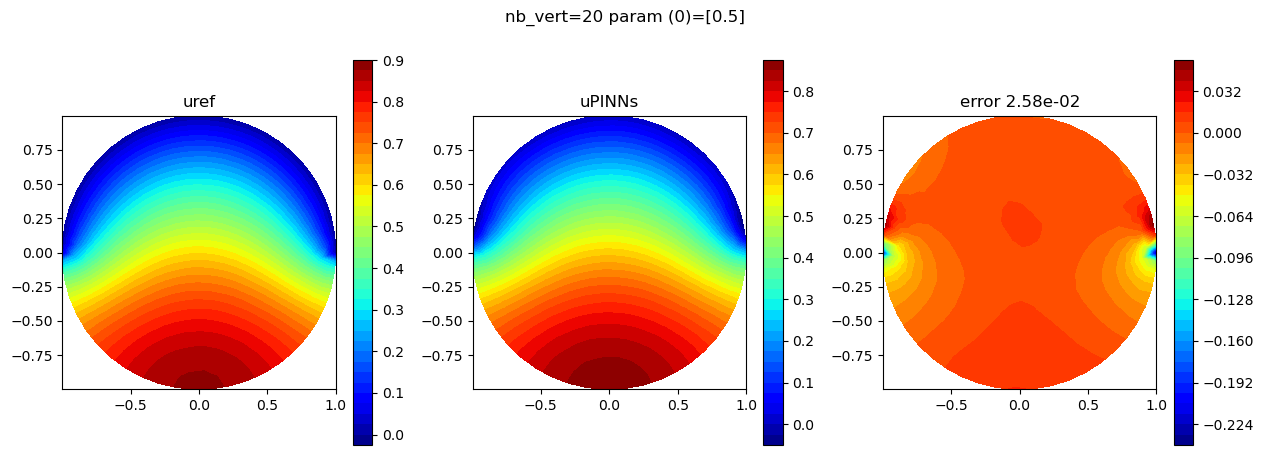


nb_vert=40
hmax =  0.06895832285674866
param = 0 

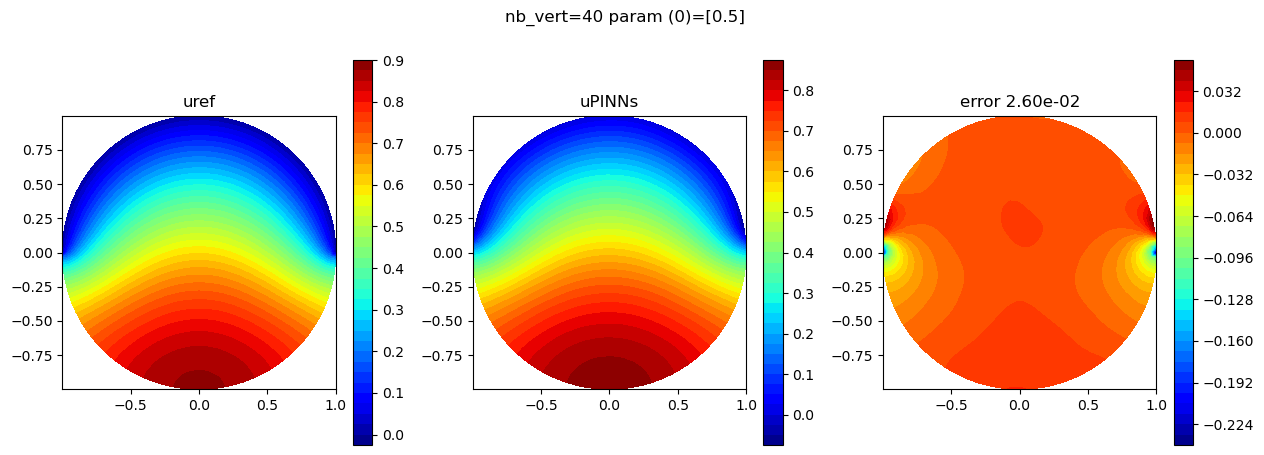

In [19]:
df_PINNs, tab_err_PINNs = run_PINNs(degree,new_run=True)